In [ ]:
# Install required libs
!pip install albumentations  
!pip install segmentation-models-pytorch

## Training a segmentation model to extract the cells from the C. elegans embryo 

In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

import segmentation_models_pytorch as smp
from albumentations import *
import time

## Loading the training images and masks 

In [ ]:
!cp /content/drive/"My Drive"/segmentation/3d_segmentation/training_data.zip /content/
!cp /content/drive/"My Drive"/segmentation/3d_segmentation/metadata.csv /content/

In [ ]:
!unzip training_data.zip 

In [ ]:
def dilate(image):
    kernel = np.ones((3, 3), np.uint8) 
    image = cv2.dilate(image,kernel,iterations = 2)
    return image

def canny(gray):
    im = cv2.Canny(gray,100,200,apertureSize = 5)
    return im

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

## Altering the original training data

The original training masks have very thin boundaries and different values for different cells, so in order to make the masks more uniform, we do the following:

* Run a canny edge detector to extract the edges 
* Dilate the edges to make the edges less noisy and more prominent 
* Subtract dilated edges on the thresholded original image 

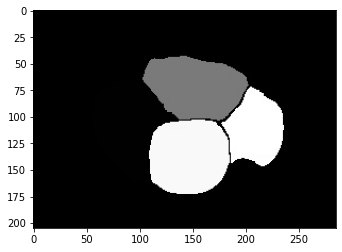

In [ ]:
df = pd.read_csv("metadata.csv")
im = cv2.imread(df["mask"].values[100])
plt.imshow(im)

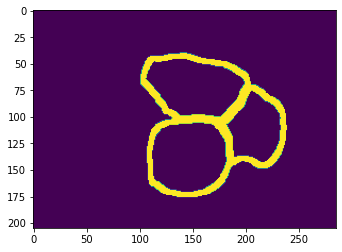

In [ ]:
foo = dilate(canny(im))
plt.imshow(foo)

In [ ]:
class SegmentationDataset(Dataset):   
    def __init__(self, metadata_csv, augmentation =None, transform_image = None, transform_label = None):
        self.metadata = pd.read_csv(metadata_csv)
        
        
        self.image_paths  = self.metadata["image"]
        self.mask_paths  =  self.metadata["mask"]
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.augmentation = augmentation


    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], 0)
        mask = cv2.imread(self.mask_paths[idx], 0)

        if self.augmentation is not None:
                
            augmented  = self.augmentation(image = image, mask = mask)
            image = augmented["image"]
            mask = augmented["mask"]
       
        mask[mask != 0] = 255

        border = dilate(canny(mask))
        mask = mask - border

        return self.transform_image(image), self.transform_label(mask)
    
    def __len__(self):
        return len(self.image_paths)

## Setting up the augmentation pipeline and the torch transforms 

* All the images are resized to `(256,256)` with augmentations like distortions, random flips, and random brightness asjustments.

* We also add Gaussian noise randomly to the input images so that the model learns to "handle" low quality and noisy images. 

In [ ]:
full_dataset = SegmentationDataset(metadata_csv = "metadata.csv",
                                    augmentation =  Compose([
                                                            GridDistortion(p=0.5),
                                                            Transpose(p=0.5),
                                                            VerticalFlip(p=0.5),
                                                            HorizontalFlip(p=0.5),
                                                            RandomRotate90(p=0.5),
                                                            RandomBrightnessContrast( p=0.5),
                                                            ShiftScaleRotate(p=0.1),
                                                            ]),

                                    transform_image = transforms.Compose([ 
                                                                    transforms.ToPILImage(),
                                                                    transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                                    ToTensor(),
                                                                    transforms.RandomApply([AddGaussianNoise( mean = 0.5,std= 0.05)], p=0.5)
                                                                ]),                                  
                                    transform_label = transforms.Compose([ 
                                                                                                        
                                                                    transforms.ToPILImage(),
                                                                    transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                                    ToTensor(),

                                                                ]))

In [ ]:
train_batch_size = 16
train_size = int(0.8* len(full_dataset))  ## 80/20 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 4, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")
sample = next(iter(train_loader))

447 batches 
447  batches 


## Viewing a batch of the training images 

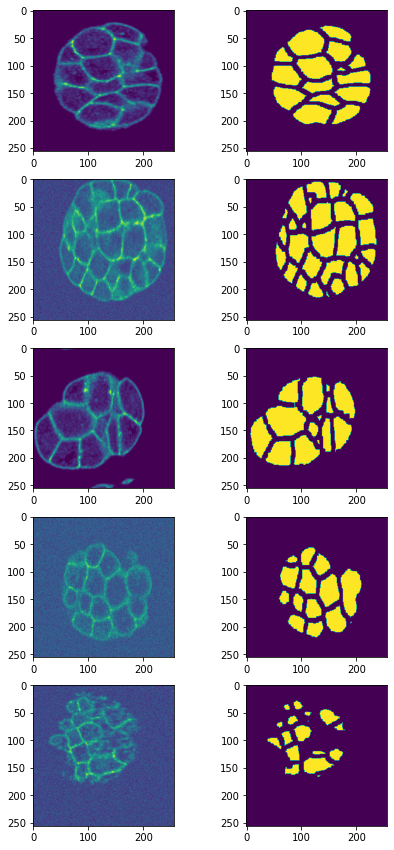

In [ ]:
batch  = next(iter(train_loader))

images, masks = batch
fig, ax = plt.subplots(5, 2, figsize = (7,15))

for i in range(5):

    ax[i][0].imshow(images[i][0])
    ax[i][1].imshow(masks[i][0])


In [ ]:
# workaround to fix model download 
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context


## Setting up the ResNet18 backbone for training 

* There is only one class in our case, i.e the cells within the embryo

* The model would return a probaility heatmap with values between 0 and 1

In [ ]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["nucleus"]
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
in_channels = 1

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    in_channels = in_channels 
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

## The LR scheduler 

`ReduceLROnPlateau` reduces the learning rate whenever it detects a plateuau in the loss curve, the parameter `patience` determines how long the scheduler has to wait on a plateaued loss before decresing the learning rate. 

In [ ]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00015),
])

scheduler = ReduceLROnPlateau(optimizer, 
                                mode='min', 
                                factor=0.7, 
                                patience=7, 
                                verbose=False, 
                                threshold=0.0001, 
                                threshold_mode='rel', 
                                cooldown=0, 
                                min_lr=0, 
                                eps=1e-08)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=False,
)


In [ ]:
max_score = 0
dice_losses = []
iou_scores  = []
times = []
lrs = []

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## Training for 30 epochs 

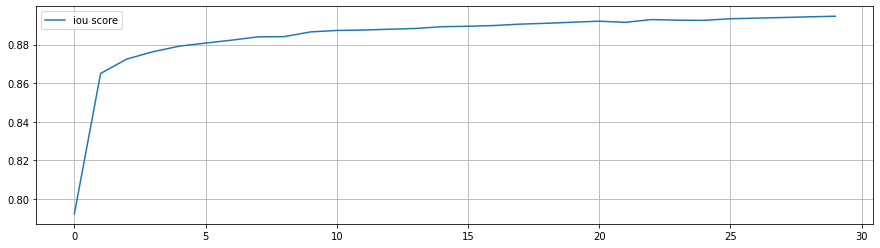

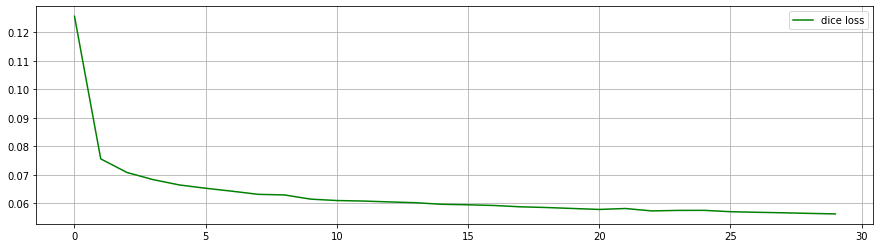

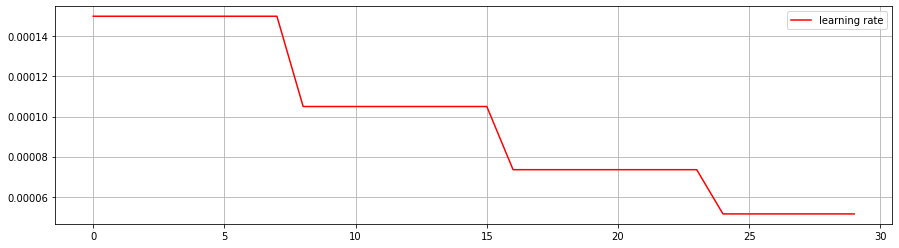

In [ ]:
epochs = 30
plt.rcParams['figure.figsize'] = 15, 4
start_time = time.process_time()

for i in range(0, epochs):

    print('\nEpoch: {}'.format(i))

    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)

    dice_losses.append(train_logs["dice_loss"]) 
    times.append(time.process_time() - start_time)
    iou_scores.append(train_logs["iou_score"])

    scheduler.step(1.)
    lrs.append(get_lr(optimizer))

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    clear_output(wait = True)
    
    plt.plot(iou_scores, label = "iou score")
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(dice_losses, color = "green", label = "dice loss")
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(lrs, label = "learning rate", color = "red")
    plt.legend()
    plt.grid()
    plt.show()


## Viewing the model's predictions 

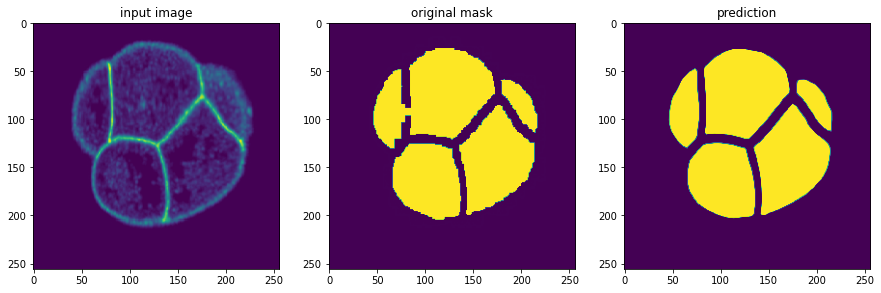

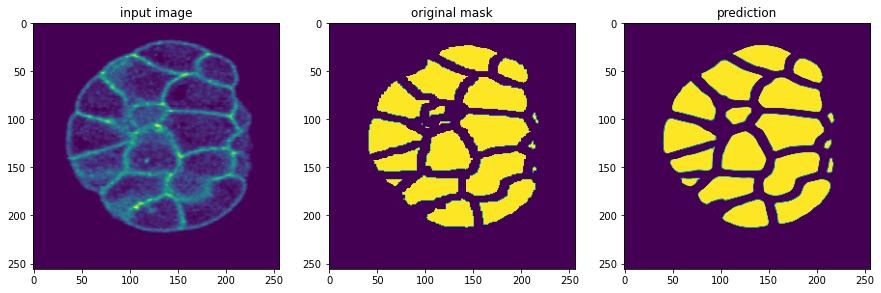

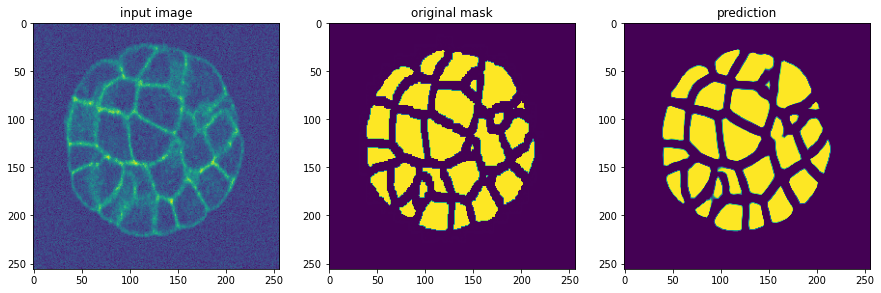

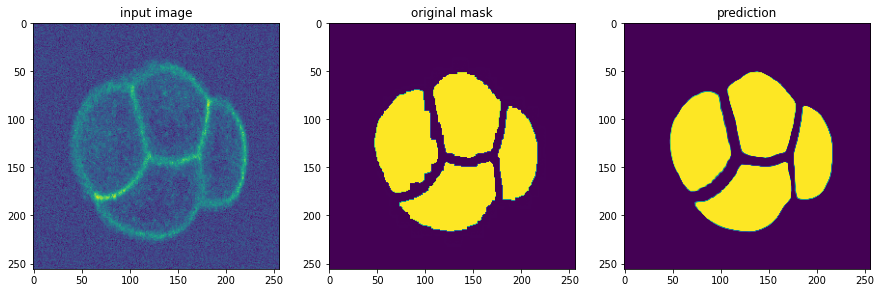

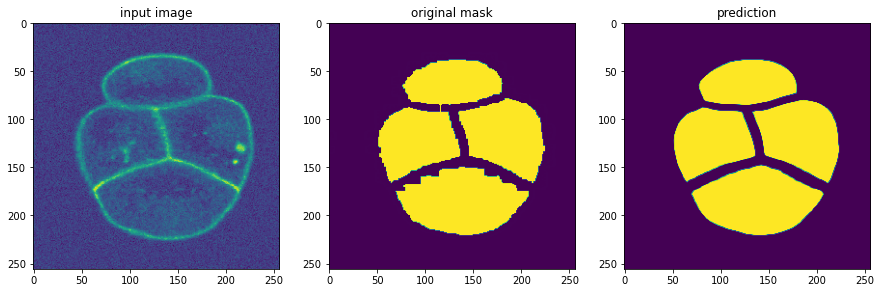

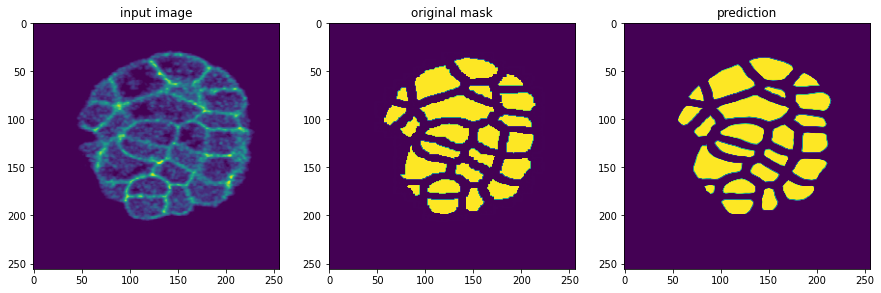

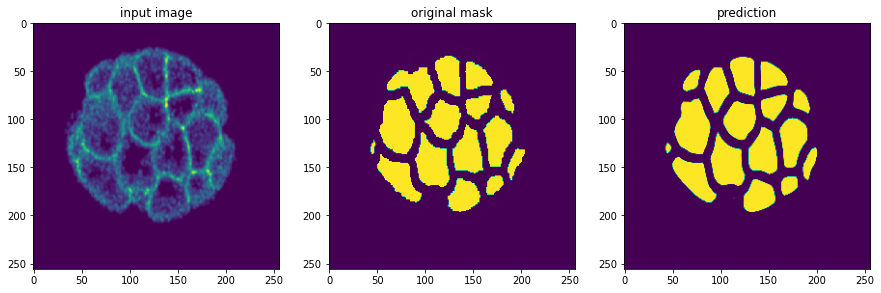

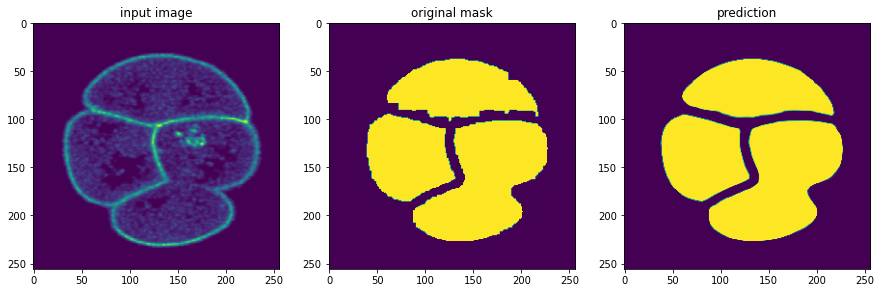

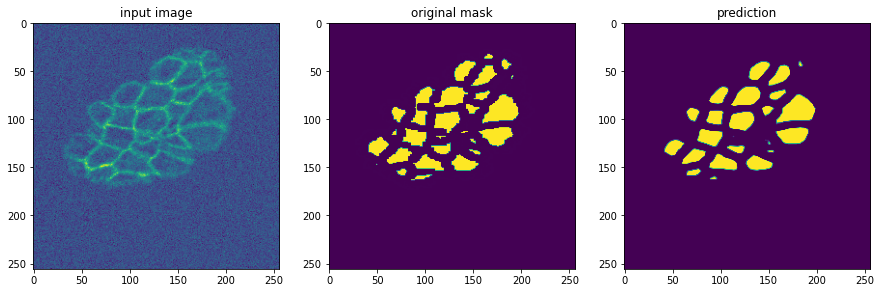

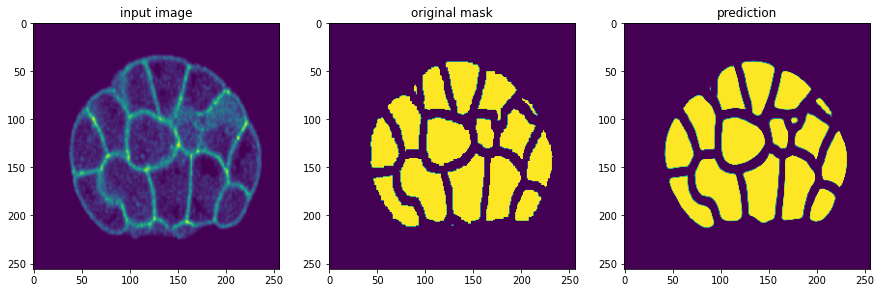

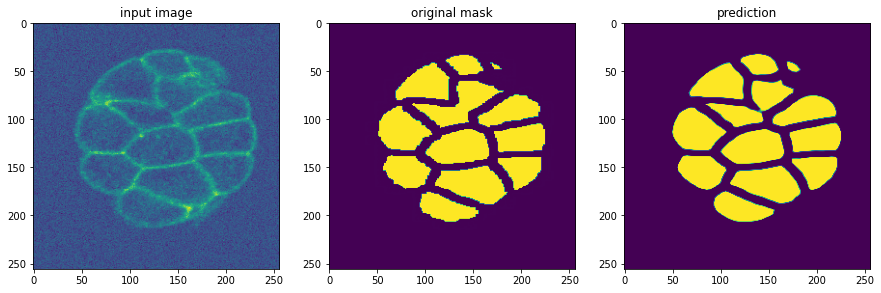

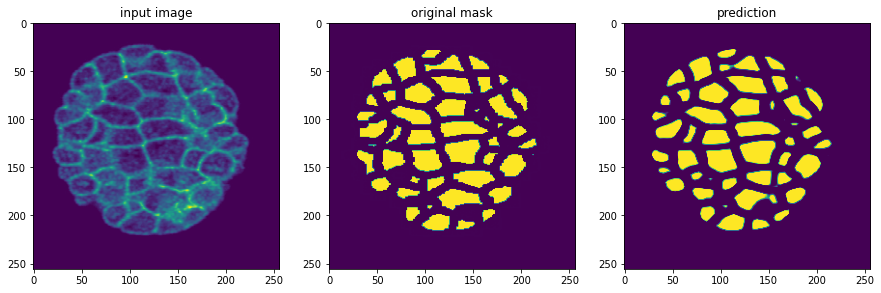

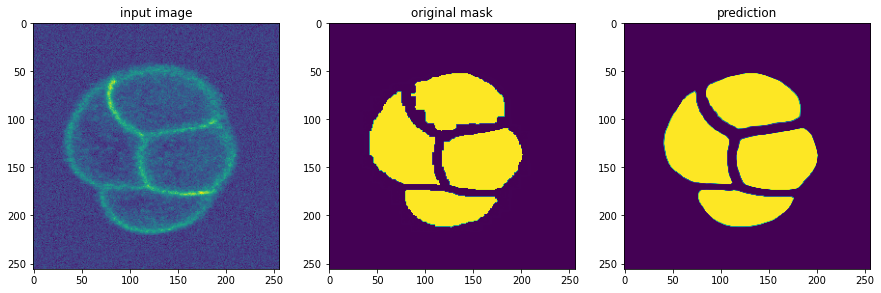

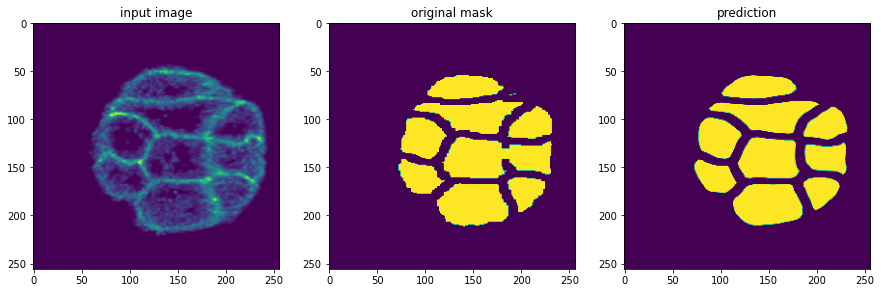

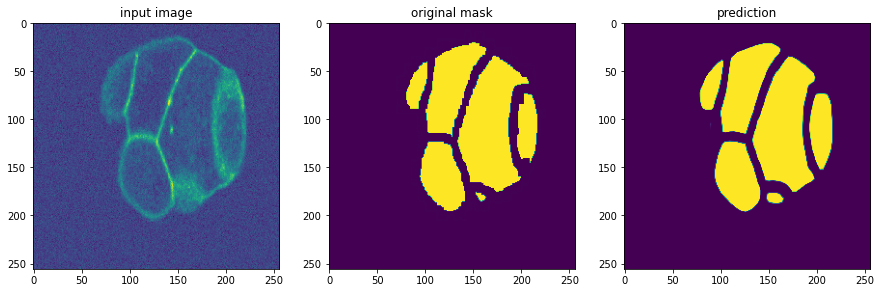

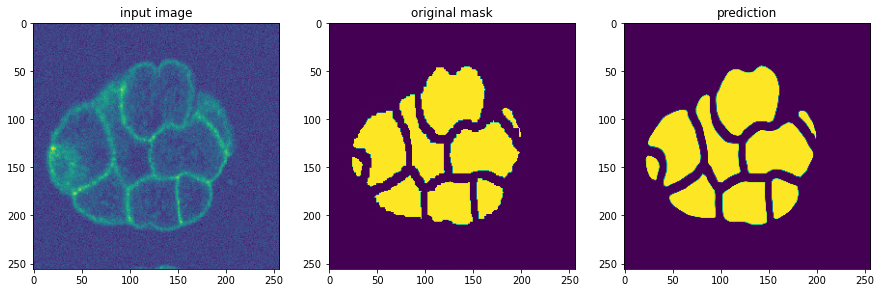

In [ ]:
image, masks = next(iter(train_loader))
 
for i in range(len(image)):
    inp = image[i].cuda().unsqueeze(0)
    pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    show_img = inp.cpu()[0][0]
    show_pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    # show_pred[show_pred > 0.1] = 1
    show_mask = masks[i][0].cpu()
    fig, ax = plt.subplots(1,3, figsize = (15,35))
 
    ax.flat[0].imshow(show_img)
    ax.flat[0].title.set_text('input image')
    
    ax.flat[1].imshow(show_mask)
    ax.flat[1].title.set_text('original mask')
 
    ax.flat[2].imshow(show_pred)
    ax.flat[2].title.set_text('prediction')

In [ ]:
 torch.save(model, '/content/drive/My Drive/segmentation/3d_segmentation/best_model.pth')
torch.save(model, 'best_model.pth')

# Generating an animation

In [ ]:
exp = []
images = df.image.values
for i in range(len(images)):
    if images[i][-6:] == "35.jpg":
        exp.append(images[i])

In [ ]:
exp = np.sort(np.array(exp))

In [ ]:
mini_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                     transforms.Resize((256,256), interpolation = Image.NEAREST),
                                     transforms.ToTensor(),
])

def path_to_result(path, model):
    model.eval()
    im = cv2.imread(path,0)
    tensor = mini_transform(im).unsqueeze(0).cuda()
    res = model(tensor).detach().cpu().numpy()[0][0]
    return res

len(exp)

190

In [ ]:
exp = ["training_data/images/real_" + str(i) + "_35.jpg" for i in range(95)]

In [ ]:
len(exp)

95

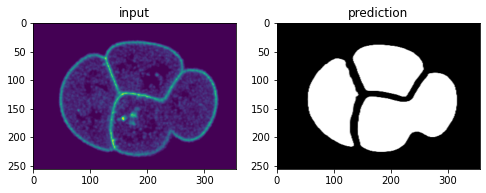

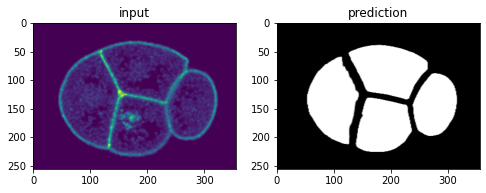

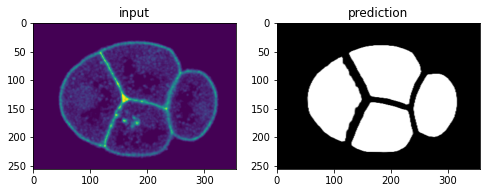

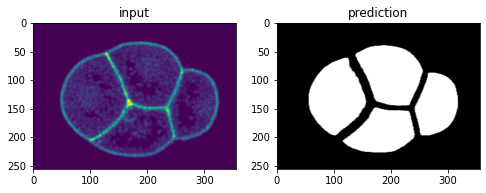

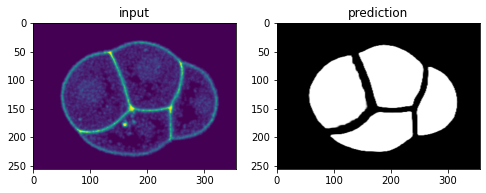

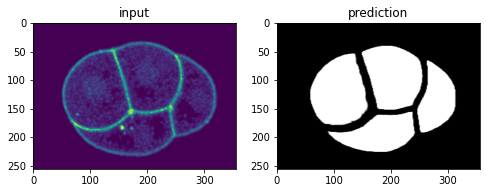

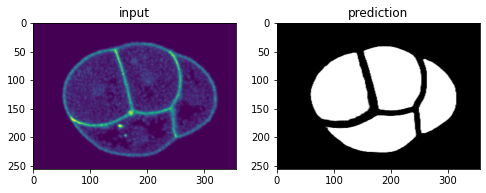

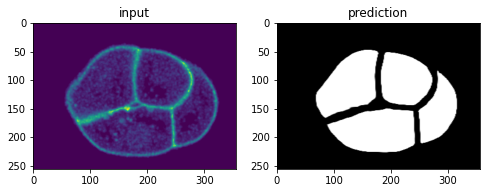

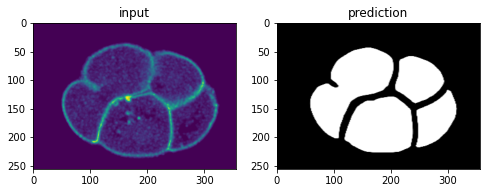

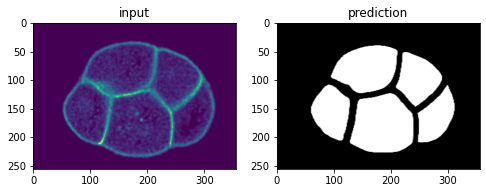

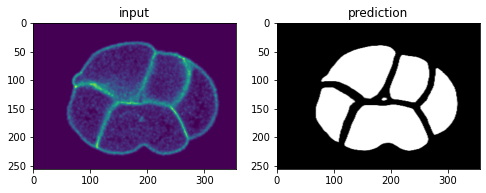

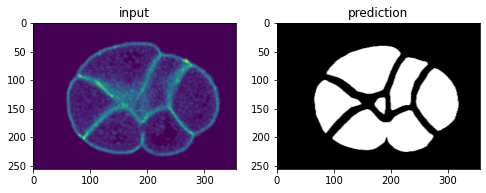

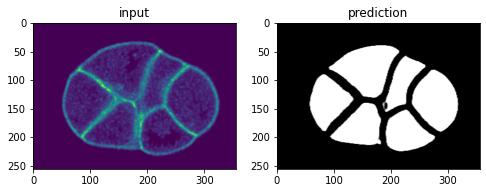

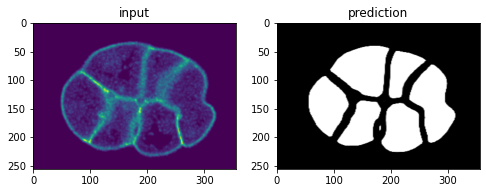

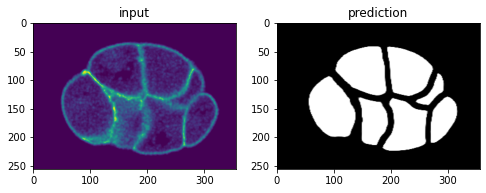

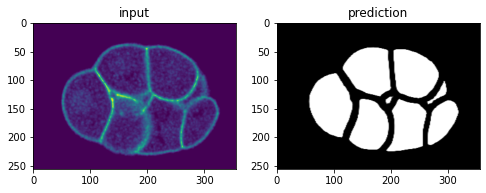

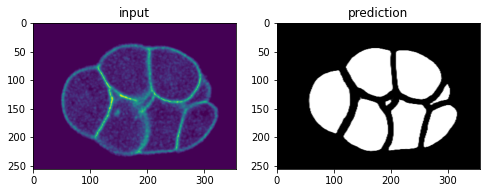

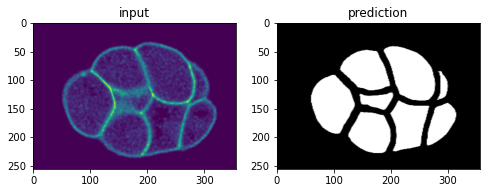

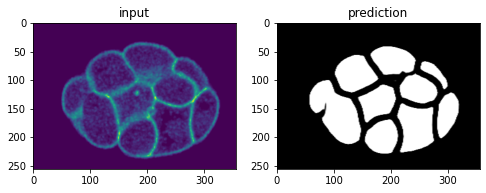

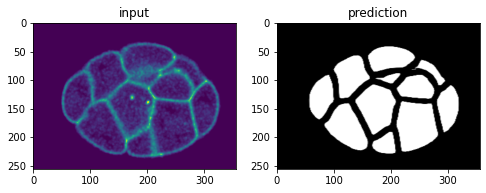

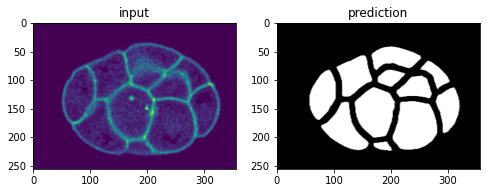

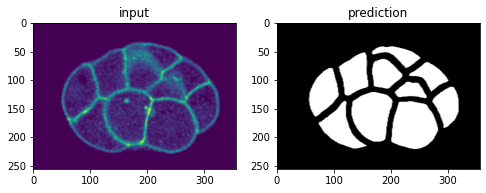

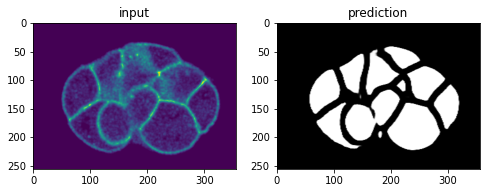

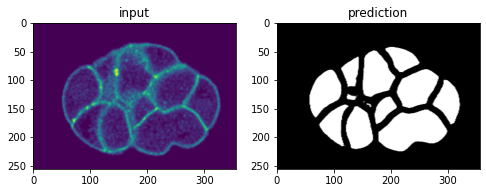

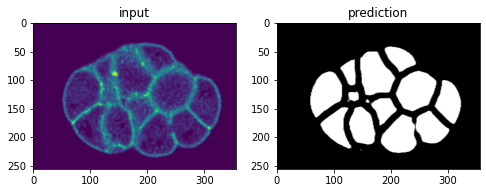

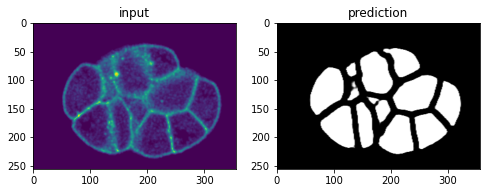

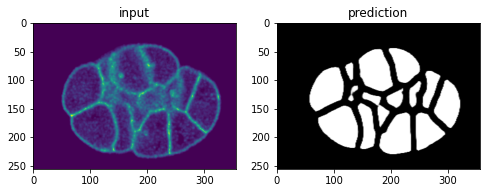

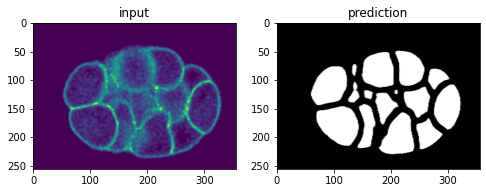

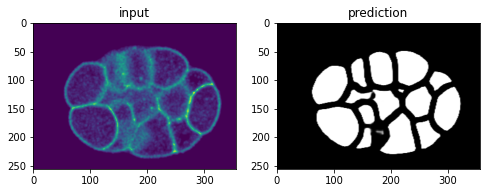

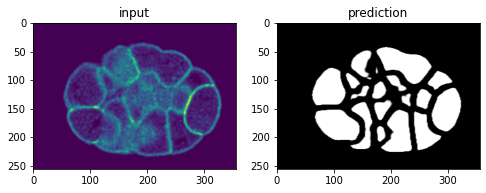

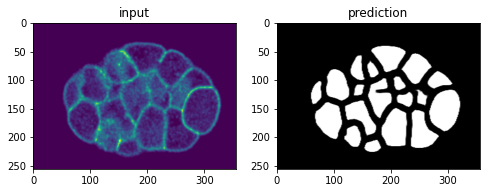

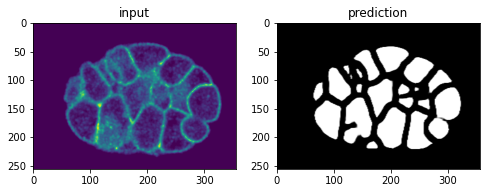

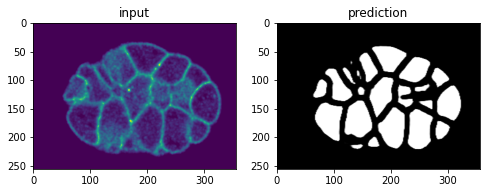

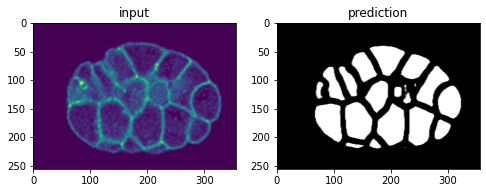

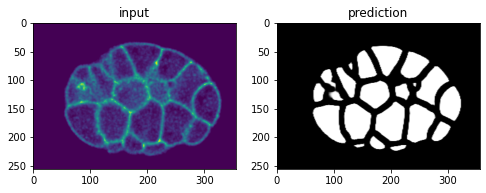

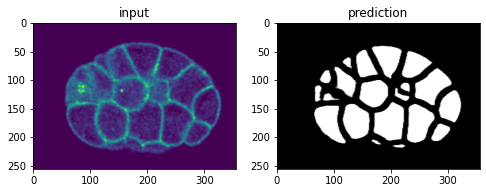

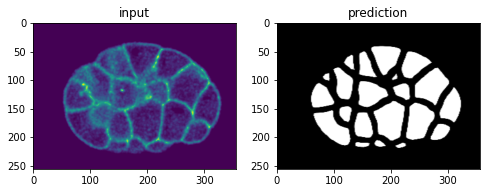

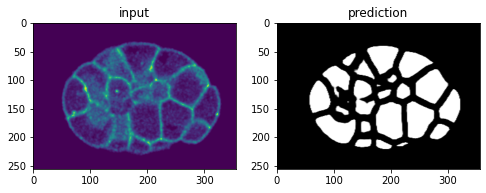

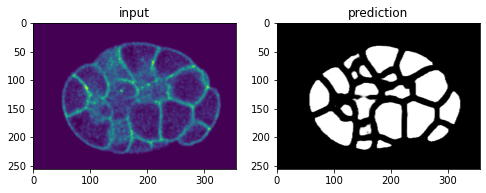

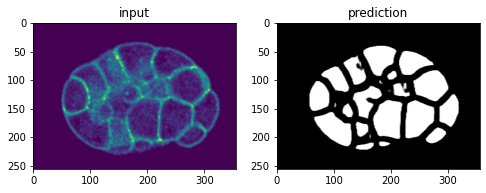

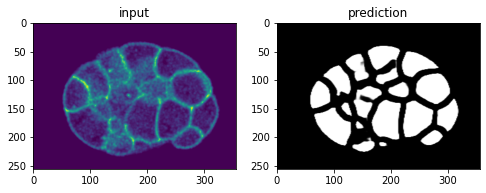

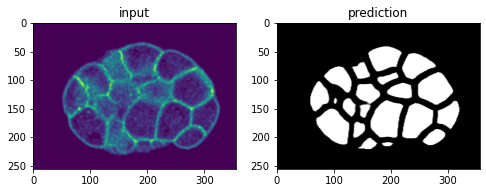

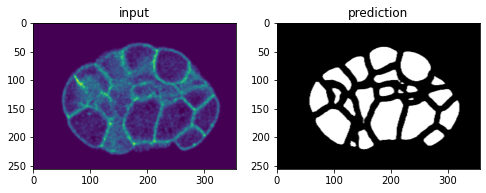

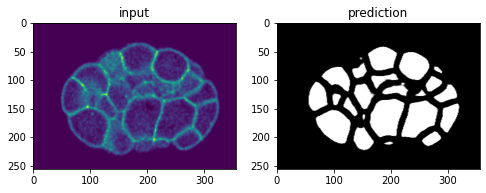

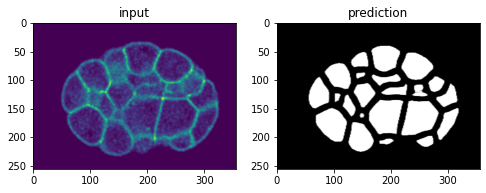

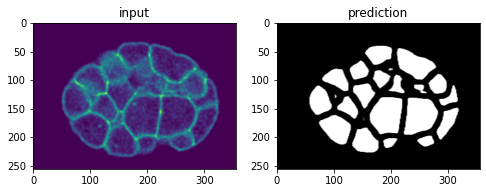

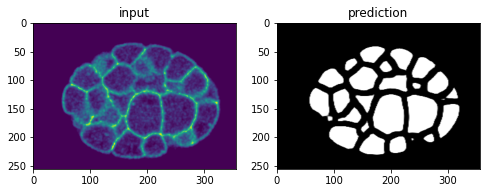

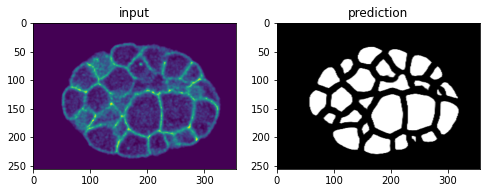

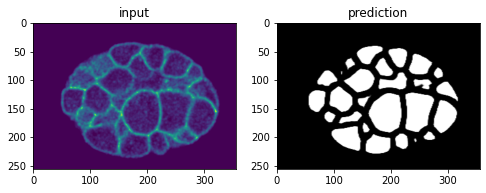

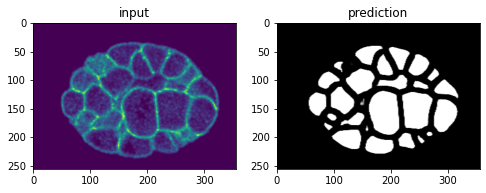

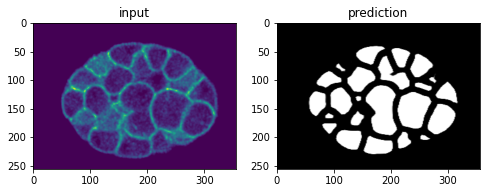

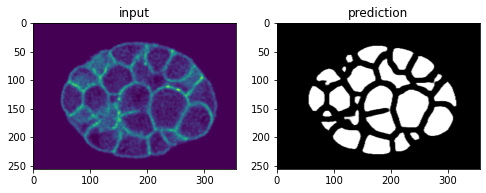

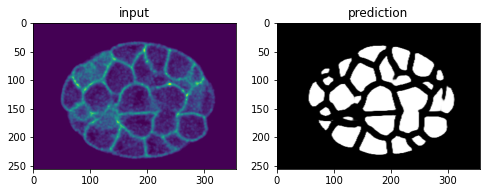

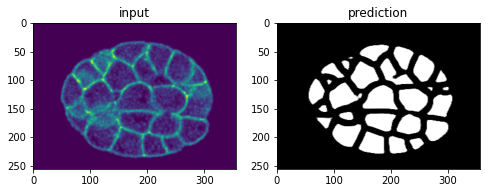

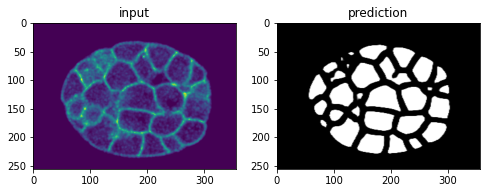

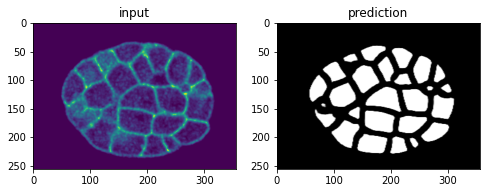

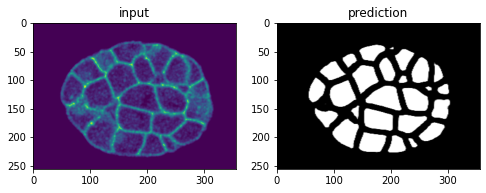

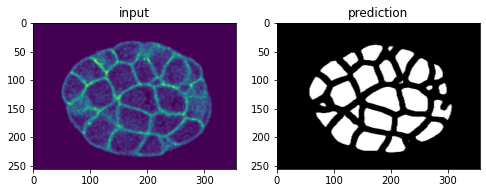

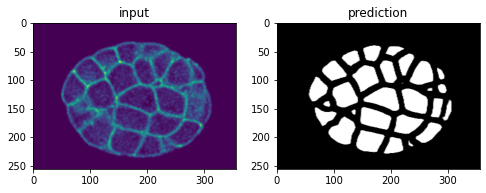

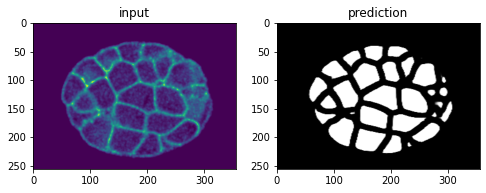

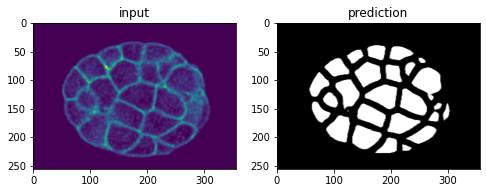

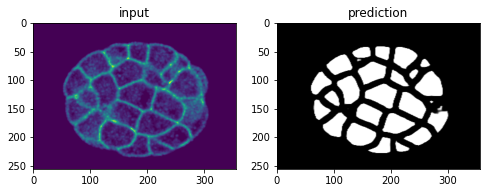

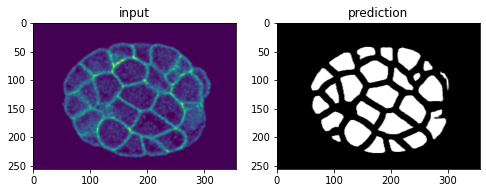

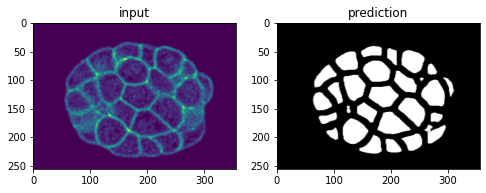

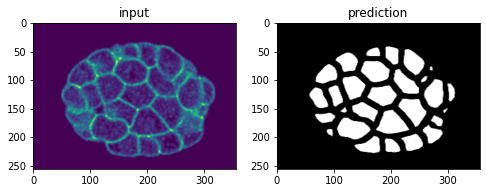

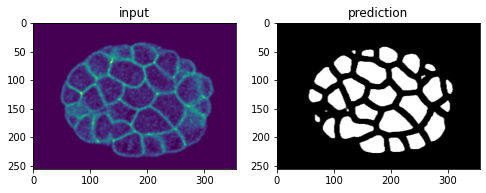

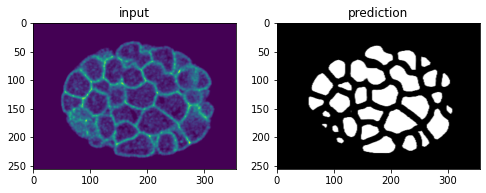

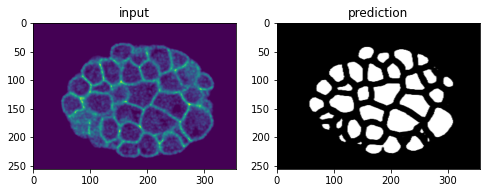

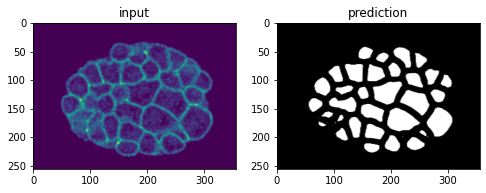

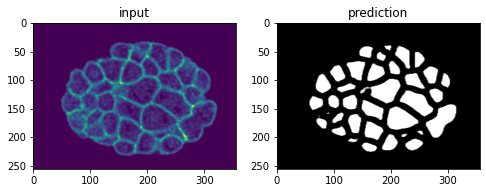

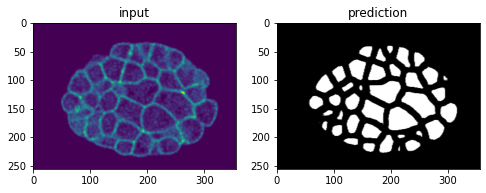

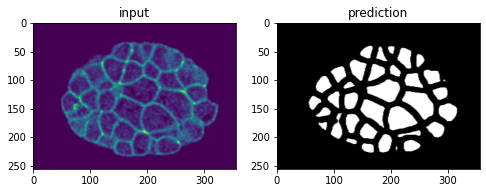

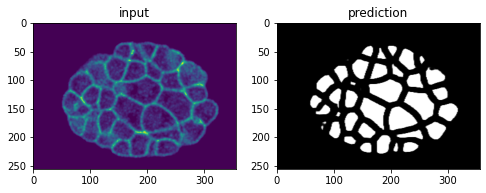

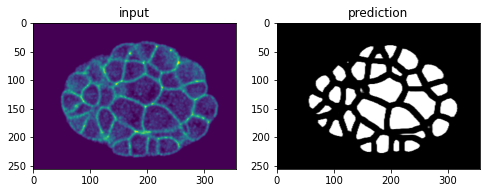

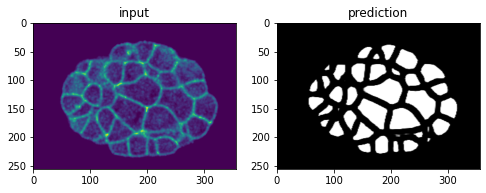

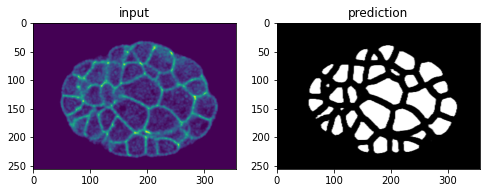

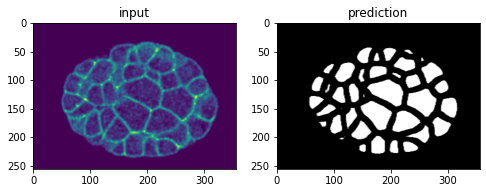

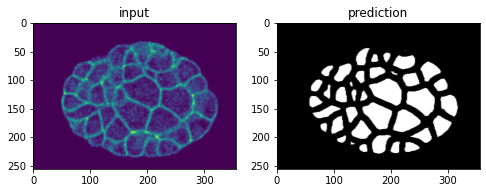

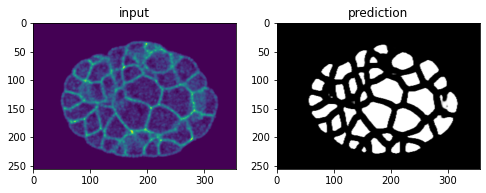

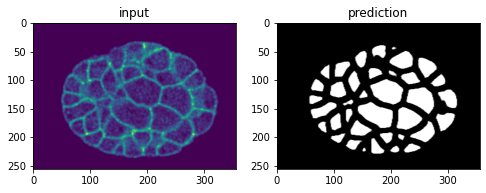

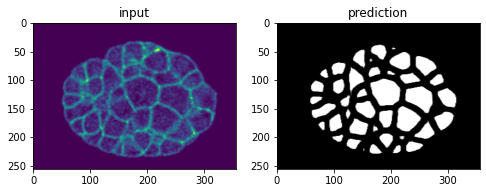

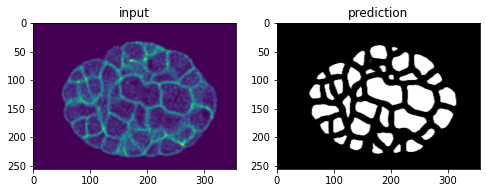

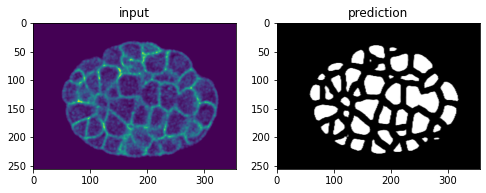

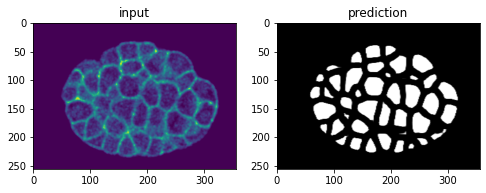

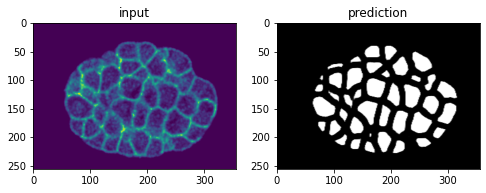

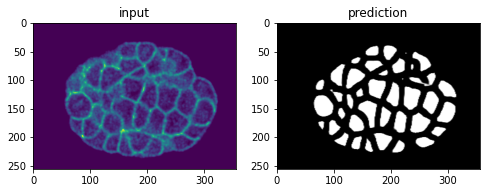

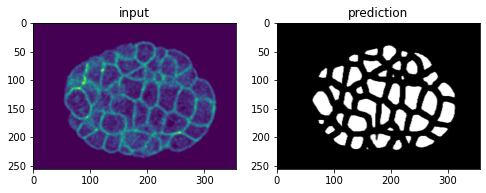

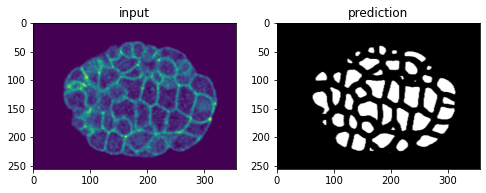

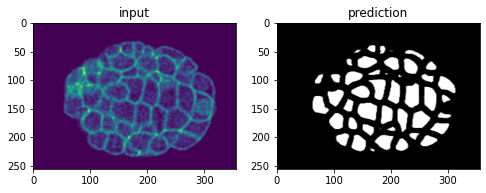

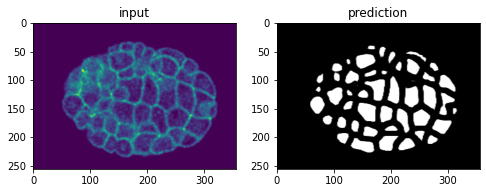

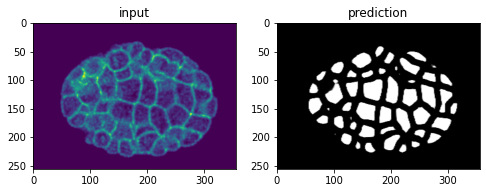

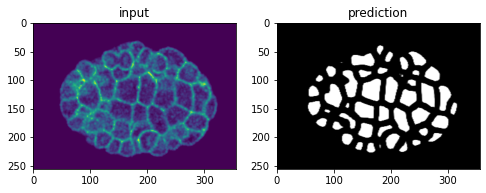

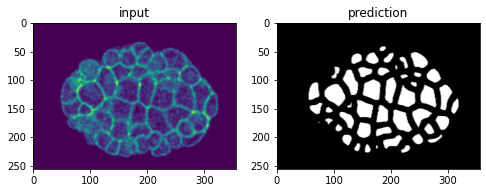

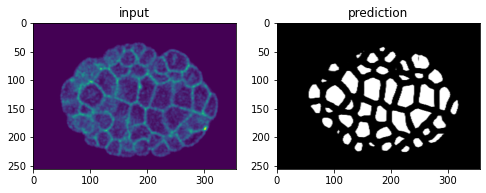

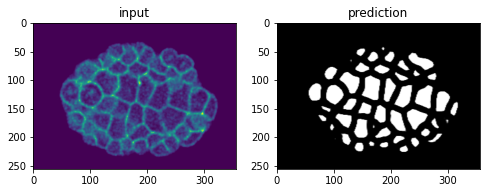

In [ ]:
model.eval()

save_folder = "animation"
# os.mkdir(save_folder)
for i in range(len(exp)):
    savename = save_folder + "/" + str(i) + ".jpg"
    fig, ax = plt.subplots(1,2, figsize = (8,4))
    pred = path_to_result(exp[i], model)
    image = cv2.imread(exp[i],0)
    pred = cv2.resize(pred, image.shape[::-1])
    clear_output(wait= True)

    ax.flat[0].imshow(image)
    ax.flat[0].title.set_text('input')
    ax.flat[1].imshow(pred, cmap = "gray")
    ax.flat[1].title.set_text('prediction')

    fig.savefig(savename)

In [ ]:
names = [ "animation/" + str(i) + ".jpg" for i in range (0, len(exp), 1)]
images = []
for n in names:
    frame = Image.open(n)
    images.append(frame)
print(len(images))

95


In [ ]:
images[0].save('pred.gif',
               save_all=True,
               append_images=images[1:],
               duration=100,
               loop=0)